In [30]:
# 必要なライブラリのインポート
import json
import pandas as pd
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union


In [31]:
# セル1: データの読み込み

# ノード特徴量が保存されたCSVファイルのパスを指定
node_data_path = '../output/nodes_data/nodes_data.csv'  # 必要に応じてファイルパスを変更
nodes_df = pd.read_csv(node_data_path)

# JSONファイルのパスを指定
json_file_path = '../rplan_json/shifted_external/1014_processed.json'  # 必要に応じてファイルパスを変更
with open(json_file_path, 'r') as f:
    data = json.load(f)

# 必要なデータを取得
rooms_data = data['processed_data']['stage5_final_alignment']['rooms']
doors_data = data['processed_data']['stage5_final_alignment']['doors']
external_walls_data = data['processed_data']['stage5_final_alignment']['external_walls']


In [32]:
# セル2: ROOM_CLASSのマッピング

ROOM_CLASS = {
    "living_room": 1,
    "kitchen": 2,
    "bedroom": 3,
    "bathroom": 4,
    "balcony": 5,
    "entrance": 6,
    "dining room": 7,
    "study room": 8,
    "storage": 10,
    "front door": 15,
    "unknown": 16,
    "interior_door": 17
}

# room_type番号からクラス名へのマッピングを作成
room_type_to_class = {v: k for k, v in ROOM_CLASS.items()}

# クラス名をノードクラスに合わせて修正
room_type_to_node_class = {
    1: 'living_room',
    2: 'kitchen',
    3: 'bedroom',
    4: 'bathroom',
    5: 'balcony',
    6: 'entrance',
    7: 'dining_room',
    8: 'study_room',
    10: 'storage',
    15: 'front_door',
    17: 'interior_door'
}

# 不明なroom_typeは'empty'として扱います
default_node_class = 'empty'


In [33]:
# セル3: 部屋のポリゴンとクラスのリスト作成

room_polygons_with_class = []

for room in rooms_data:
    coordinates = room['polygon']['coordinates'][0]
    polygon = Polygon(coordinates)
    room_type = room['room_type']
    node_class = room_type_to_node_class.get(room_type, default_node_class)
    room_polygons_with_class.append({
        'polygon': polygon,
        'class': node_class
    })


In [34]:
# セル4: ドアのラインとクラスの作成

door_lines_with_class = []

for door in doors_data:
    p1 = door['p1']
    p2 = door['p2']
    line = LineString([p1, p2])
    door_type = door['type']
    if door_type == 15:
        node_class = 'front_door'
    elif door_type == 17:
        node_class = 'interior_door'
    else:
        node_class = 'unknown_door'
    door_lines_with_class.append({
        'line': line,
        'class': node_class
    })


In [35]:
from shapely.geometry import Point

nodes_df['node_class'] = default_node_class  # 初期値として 'empty' を設定

for index, node in nodes_df.iterrows():
    point = Point(node['x'], node['y'])
    
    # 1. 境界外にあるノードは 'empty' クラス
    if node['outside_boundary'] == 1:
        nodes_df.at[index, 'node_class'] = 'empty'
        continue  # 以降の判定は不要
    
    # 2. ドア上にあるかどうかを判定（ドアは最優先で判定）
    is_on_door = False
    for door in door_lines_with_class:
        if door['line'].distance(point) < 1e-6:
            nodes_df.at[index, 'node_class'] = door['class']
            is_on_door = True
            break
    if is_on_door:
        continue  # ドア上であれば他の判定は不要
    
    # 3. 外壁上にあるかどうかを判定
    if node['on_external_wall'] == 1:
        nodes_df.at[index, 'node_class'] = 'exterior_wall'
        continue  # 他の判定は不要
    
    # 4. 内壁上にあるかどうかを判定
    if node['on_internal_wall'] == 1:
        nodes_df.at[index, 'node_class'] = 'interior_wall'
        continue  # 他の判定は不要
    
    # 5. 部屋内にあるかどうかを判定
    is_in_room = False
    for room in room_polygons_with_class:
        if room['polygon'].contains(point) or room['polygon'].touches(point):
            nodes_df.at[index, 'node_class'] = room['class']
            is_in_room = True
            break
    if is_in_room:
        continue  # 部屋内であれば他の判定は不要

In [36]:
# セル6: ノードクラスの集計

node_class_counts = nodes_df['node_class'].value_counts()
print(node_class_counts)


node_class
empty            1547
living_room       204
bedroom           164
exterior_wall      97
interior_wall      37
kitchen            32
bathroom           20
interior_door      12
front_door          3
Name: count, dtype: int64


In [37]:
# セル7: ノードデータの保存

# CSVファイルとして保存
output_path = '../output/nodes_data/nodes_with_classes.csv'  # 出力ファイルのパスを指定
nodes_df.to_csv(output_path, index=False)

print(f"Classified nodes saved to {output_path}")


Classified nodes saved to ../output/nodes_data/nodes_with_classes.csv


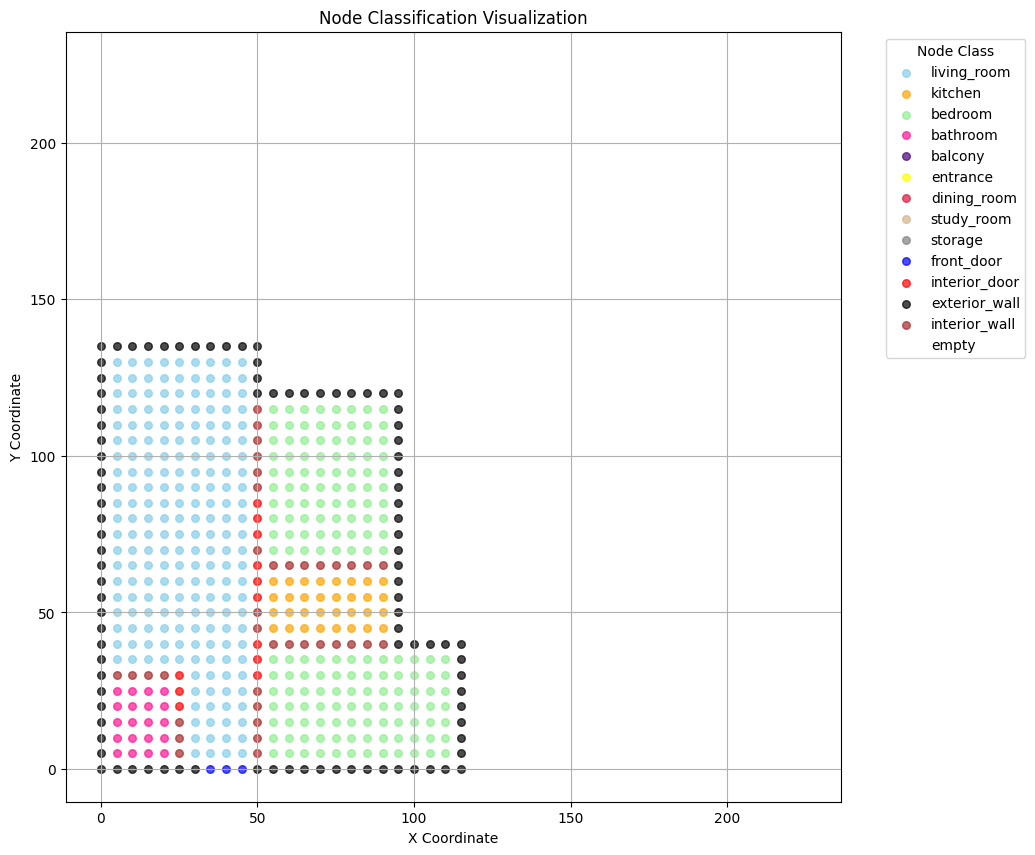

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# データの読み込み
csv_file_path = '../output/nodes_data/nodes_with_classes.csv'  # 必要に応じてファイルパスを変更
nodes_df = pd.read_csv(csv_file_path)

# 固定色の割り当て
ROOM_TYPE_COLORS = {
    'living_room': 'skyblue',
    'kitchen': 'orange',
    'bedroom': 'lightgreen',
    'bathroom': 'deeppink',
    'balcony': 'indigo',
    'entrance': 'yellow',
    'dining_room': 'crimson',
    'study_room': 'tan',
    'storage': 'gray',
    'front_door': 'blue',
    'interior_door': 'red',
    'exterior_wall': 'black',
    'interior_wall': 'brown',
    'empty': 'white'
}

# 可視化
plt.figure(figsize=(10, 10))
plt.title("Node Classification Visualization")

# 各クラスごとに色を設定してプロット
for node_class, color in ROOM_TYPE_COLORS.items():
    # クラスごとのデータを取得
    class_nodes = nodes_df[nodes_df['node_class'] == node_class]
    plt.scatter(class_nodes['x'], class_nodes['y'], c=color, label=node_class, s=30, alpha=0.7)

# 凡例を表示
plt.legend(title="Node Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.axis("equal")

# グラフの表示
plt.show()